In [1]:
from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)



1

In [2]:
# https://github.com/NSLS-II-OPLS/profile_collection/blob/6960f16e4b622e1cc2bf4703cfa07e3340a617f2/startup/45-pilatus.py#L53-L54

from ophyd import ( Component as Cpt, ADComponent, Device, PseudoPositioner,
                    EpicsSignal, EpicsSignalRO, EpicsMotor,
                    ROIPlugin, ImagePlugin,
                    SingleTrigger, PilatusDetector,
                    OverlayPlugin, FilePlugin, TIFFPlugin, SimDetector, TIFFPlugin, StatsPlugin, SimDetectorCam)
from ophyd.areadetector.filestore_mixins import FileStoreTIFFIterativeWrite
from ophyd import Component as Cpt

class SimDetectorCamV33(SimDetectorCam):
    '''This is used to update the SimDetectorCam to AD33.'''

    wait_for_plugins = Cpt(EpicsSignal, 'WaitForPlugins',
                           string=True, kind='config')

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.stage_sigs['wait_for_plugins'] = 'Yes'

    def ensure_nonblocking(self):
        self.stage_sigs['wait_for_plugins'] = 'Yes'
        for c in self.parent.component_names:
            cpt = getattr(self.parent, c)
            if cpt is self:
                continue
            if hasattr(cpt, 'ensure_nonblocking'):
                cpt.ensure_nonblocking()
    


class SimDetector(SimDetector):
    cam = Cpt(SimDetectorCamV33, 'cam1:')

class TIFFPluginWithFileStore(TIFFPlugin, FileStoreTIFFIterativeWrite):
    ...

class MySimDetector(SingleTrigger, SimDetector):
    tiff = Cpt(TIFFPluginWithFileStore,
               suffix="TIFF1:",
               write_path_template="/home/emil/Apps/autosave/images/")
    stats = Cpt(StatsPlugin, 'Stats1:')
    image = Cpt(ImagePlugin, 'image1:')

def set_detector(det):

    det.tiff.kind = 'normal' 
    det.stats.kind = 'hinted'
    det.image.kind = 'hinted'
    det.stats.total.kind = 'hinted'
    det.stats.centroid.x.kind = 'hinted' 
    det.stats.centroid.y.kind = 'hinted' 
    det.cam.ensure_nonblocking()



In [3]:
my_sim_cam = MySimDetector('SISSY1EX:Simdetector1:', name='test')


In [4]:
my_sim_cam.wait_for_connection()

In [5]:
set_detector(my_sim_cam)


In [6]:
my_sim_cam.read

<bound method Device.read of MySimDetector(prefix='SISSY1EX:Simdetector1:', name='test', read_attrs=['tiff', 'stats', 'stats.total', 'image'], configuration_attrs=['cam', 'cam.acquire_period', 'cam.acquire_time', 'cam.image_mode', 'cam.manufacturer', 'cam.model', 'cam.num_exposures', 'cam.num_images', 'cam.trigger_mode', 'tiff', 'stats', 'image'])>

In [7]:
import databroker.core
handler_registry = databroker.core.discover_handlers()


In [8]:
from bluesky.plans import count
RE(count([my_sim_cam]))



Transient Scan ID: 1     Time: 2021-07-28 16:28:57
Persistent Unique Scan ID: 'f36bf3da-c4c0-4405-9659-1400e5b9d826'
New stream: 'primary'
+-----------+------------+------------------+
|   seq_num |       time | test_stats_total |
+-----------+------------+------------------+
|         1 | 16:28:58.0 |          4874148 |
+-----------+------------+------------------+
generator count ['f36bf3da'] (scan num: 1)





('f36bf3da-c4c0-4405-9659-1400e5b9d826',)

In [9]:
run = db[-1]

In [10]:
ls /home/emil/Apps/autosave/images/

2556d0cd-2282-4afe-9ec7_000000.tiff  b682341a-de46-4995-b49e_000000.tiff
3a56a0a7-bd8a-458c-b460_000000.tiff  bbcf1338-a119-46b1-bde5_000000.tiff
3d3f9c98-a94f-4224-906c_000000.tiff  c4d4cb28-ecac-4a15-9a93_000000.tiff
52aede23-b7f3-4308-ae24_000000.tiff  c4f83825-db64-46d2-8e20_000000.tiff
55354b9a-7301-4e59-bbf4_000000.tiff  c614ee9a-e0da-4cd2-8d9b_000000.tiff
5c749204-16d7-493b-80a1_000000.tiff  d36c1ba8-5d9a-43a8-8051_000000.tiff
64143efa-76fd-4ae3-a147_000000.tiff  d3a75c12-8f1d-4989-aeeb_000000.tiff
701df64a-6911-4edf-89b9_000000.tiff  ddc99332-00fe-43c6-b580_000000.tiff
77de774b-8aa0-4e4d-a1a1_000000.tiff  de0872c3-d260-4dfd-8f58_000000.tiff
85529d9f-8974-46b0-84a5_000000.tiff  ea38ee7b-59f2-41b1-9e8c_000000.tiff
9f6b161f-221d-4f3d-a731_000000.tiff  fa9fb9b2-5110-4308-9aaf_000000.tiff


In [40]:
import os
from pathlib import Path
file = '/home/emil/Apps/autosave/images/fa9fb9b2-5110-4308-9aaf_000000.tiff'
import os
os.stat(file)
#os.stat_result(st_mode=33188, st_ino=6419862, st_dev=16777220, st_nlink=1, st_uid=501, st_gid=20, st_size=1564, st_atime=1584299303, st_mtime=1584299400, st_ctime=1584299400)
os.stat(file).st_size

1048874

In [ ]:
import os

 = '/home/emil/Apps/autosave/images/fa9fb9b2-5110-4308-9aaf_000000.tiff'
my_dir = ''
file_name = 'test.tiff'
fname = os.path.join(my_dir, file_name)
file = open(fname,'w')
file.write()

In [11]:
list(run)


['primary']

In [25]:
%matplotlib inline
tiff_file = '/home/emil/Apps/autosave/images/fa9fb9b2-5110-4308-9aaf_000000.tiff'
from PIL import Image
im = Image.open(tiff_file)
im.show()

AttributeError: 'str' object has no attribute 'shape'

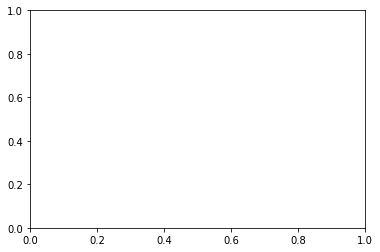

In [19]:
import numpy
imarray = numpy.array(im)


In [20]:
imarray

array([[5, 4, 1, ..., 4, 8, 3],
       [1, 4, 7, ..., 7, 8, 7],
       [9, 2, 8, ..., 6, 0, 5],
       ...,
       [0, 9, 0, ..., 7, 1, 0],
       [8, 3, 0, ..., 8, 1, 4],
       [9, 0, 1, ..., 3, 8, 9]], dtype=uint8)

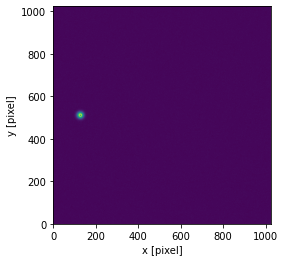

In [28]:
import matplotlib.pyplot as plt
import numpy as np
image = imarray

#1 pixel = 100 meters
r = 1./1.

fig, ax = plt.subplots()
ax.imshow(image, extent=(0,image.shape[1]/r,0,image.shape[0]/r) )
ax.set_xlabel("x [pixel]")
ax.set_ylabel("y [pixel]")  
plt.show()

In [34]:
import pickle

fname = 'image_test.pcl'
with open(fname, 'bw') as fobj: # bw binary
    pickle.dump(image, fobj)

In [35]:
with open(fname, 'br') as fobj: # bw binary
    ds = pickle.load(fobj)

In [36]:
ds

array([[5, 4, 1, ..., 4, 8, 3],
       [1, 4, 7, ..., 7, 8, 7],
       [9, 2, 8, ..., 6, 0, 5],
       ...,
       [0, 9, 0, ..., 7, 1, 0],
       [8, 3, 0, ..., 8, 1, 4],
       [9, 0, 1, ..., 3, 8, 9]], dtype=uint8)

In [32]:
#import numpy as np
#import Image

#data = np.random.randint(0, 255, (10,10)).astype(np.uint8)
#im = Image.fromarray(image)
#im.save('test.tif')

In [33]:
#from libtiff import TIFF
#tif = TIFF.open('test.tiff', mode='w')
#tif.write_image(image)

In [23]:
import matplotlib.pyplot as plt
I = plt.imread(tiff_file)
plt.show()

In [12]:
image = run.primary.read()["test_image"]


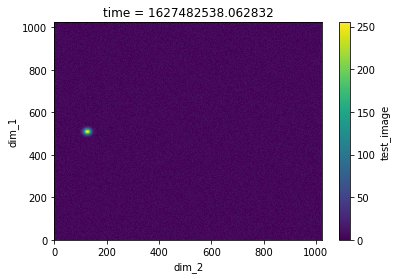

In [13]:

frame =image[0][0]
frame.plot.pcolormesh()


In [14]:
frame

<xarray.DataArray 'test_image' (dim_1: 1024, dim_2: 1024)>
array([[5, 7, 0, ..., 6, 2, 3],
       [2, 1, 1, ..., 4, 7, 3],
       [2, 3, 2, ..., 6, 1, 3],
       ...,
       [3, 9, 0, ..., 3, 5, 1],
       [7, 9, 3, ..., 9, 6, 5],
       [8, 5, 3, ..., 7, 4, 7]], dtype=uint8)
Coordinates:
    time     float64 1.627e+09
Dimensions without coordinates: dim_1, dim_2
Attributes:
    object:   test

In [15]:
image

<xarray.DataArray 'test_image' (time: 1, dim_0: 1, dim_1: 1024, dim_2: 1024)>
array([[[[2, 3, 6, ..., 0, 6, 9],
         [2, 8, 2, ..., 7, 9, 3],
         [4, 1, 0, ..., 5, 3, 5],
         ...,
         [2, 1, 2, ..., 2, 2, 0],
         [7, 7, 3, ..., 9, 7, 9],
         [7, 4, 5, ..., 6, 9, 0]]]], dtype=uint8)
Coordinates:
  * time     (time) float64 1.627e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Attributes:
    object:   test

In [19]:
image.time

<xarray.DataArray 'time' (time: 1)>
array([1.627473e+09])
Coordinates:
  * time     (time) float64 1.627e+09